### Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# !pip install mplfinance

### Importando o dataset

In [2]:
colunas = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']
df = pd.read_csv('../dataset/dataset-exemplo-202206.csv')
df.columns = colunas

In [3]:
df

,date,time,open,high,low,close,volume
0,2022.06.01,00:01,1.07181,1.07183,1.07177,1.07181,0
1,2022.06.01,00:02,1.07182,1.07183,1.07172,1.07172,0
2,2022.06.01,00:03,1.07172,1.07172,1.07157,1.07158,0
3,2022.06.01,00:04,1.07157,1.07160,1.07151,1.07160,0
4,2022.06.01,00:05,1.07162,1.07163,1.07157,1.07162,0
...,...,...,...,...,...,...,...
31521,2022.06.30,23:54,1.04521,1.04530,1.04515,1.04527,0
31522,2022.06.30,23:55,1.04527,1.04542,1.04524,1.04540,0
31523,2022.06.30,23:56,1.04541,1.04551,1.04538,1.04547,0
31524,2022.06.30,23:57,1.04547,1.04554,1.04545,1.04548,0


In [4]:
df.head()

,date,time,open,high,low,close,volume
0,2022.06.01,00:01,1.07181,1.07183,1.07177,1.07181,0
1,2022.06.01,00:02,1.07182,1.07183,1.07172,1.07172,0
2,2022.06.01,00:03,1.07172,1.07172,1.07157,1.07158,0
3,2022.06.01,00:04,1.07157,1.07160,1.07151,1.07160,0
4,2022.06.01,00:05,1.07162,1.07163,1.07157,1.07162,0


### Verificando valores omissos

In [5]:
df.isnull().sum()

date      0
time      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

### Análise e exploração dos dados

<AxesSubplot:>

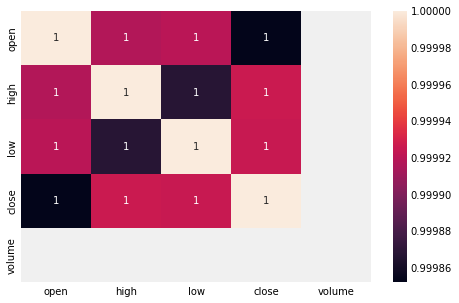

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 5))
sns.heatmap(df.corr(), annot=True)

In [7]:
df['open-high'] = df['open']-df['high']
df['open-low'] = df['open'] - df['low']
df['close-high'] = df['close']-df['high']
df['close-low'] = df['close'] - df['low']
df['high-low'] = df['high'] - df['low']
df['open-close'] = df['open'] - df['close']
df.head()

,date,time,open,high,low,close,volume,open-high,open-low,close-high,close-low,high-low,open-close
0,2022.06.01,00:01,1.07181,1.07183,1.07177,1.07181,0,-0.00002,0.00004,-0.00002,0.00004,0.00006,0.00000
1,2022.06.01,00:02,1.07182,1.07183,1.07172,1.07172,0,-0.00001,0.00010,-0.00011,0.00000,0.00011,0.00010
2,2022.06.01,00:03,1.07172,1.07172,1.07157,1.07158,0,0.00000,0.00015,-0.00014,0.00001,0.00015,0.00014
3,2022.06.01,00:04,1.07157,1.07160,1.07151,1.07160,0,-0.00003,0.00006,0.00000,0.00009,0.00009,-0.00003
4,2022.06.01,00:05,1.07162,1.07163,1.07157,1.07162,0,-0.00001,0.00005,-0.00001,0.00005,0.00006,0.00000


<AxesSubplot:>

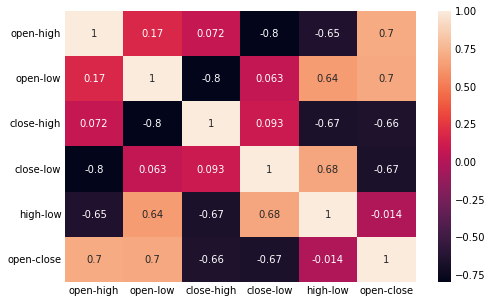

In [8]:
df2 = df.copy(True)
df2 = df2.drop(['open', 'high', 'low', 'close', 'volume'], axis=1)
plt.figure(figsize=(7, 5))
sns.heatmap(df2.corr(), annot=True)

In [9]:
# Instalar a biblitoeca
# pip install --upgrade mplfinance

In [10]:
import mplfinance as mpf

# cópia do DataFrame
df3 = df.copy(True)

# criação da coluna contendo data e tempo
df3['datetime'] = df3['date'] + ' ' + df3['time']

# conversão dos dados dessa coluna para o objeto datetime
df3['datetime'] = pd.to_datetime(df3['datetime'])

# remoção das colunas que não serão utilizadas
df3 = df3.drop(['date', 'time', 'volume', 'open-high', 'open-low',
               'close-high',	'close-low',	'high-low', 'open-close'], axis=1)

# definição da coluna datetime como índice do DataFrame
df3.set_index('datetime', inplace=True, drop=True)

# Visualização das primeiras 5 linhas
df3.head()

,open,high,low,close
datetime,,,,
2022-06-01 00:01:00,1.07181,1.07183,1.07177,1.07181
2022-06-01 00:02:00,1.07182,1.07183,1.07172,1.07172
2022-06-01 00:03:00,1.07172,1.07172,1.07157,1.07158
2022-06-01 00:04:00,1.07157,1.07160,1.07151,1.07160
2022-06-01 00:05:00,1.07162,1.07163,1.07157,1.07162


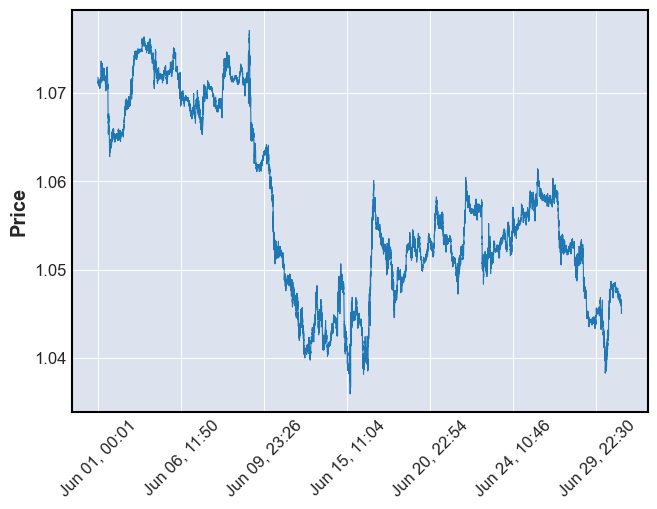

In [11]:
# Gerando o gráfico de linha
mpf.plot(df3, type='line')

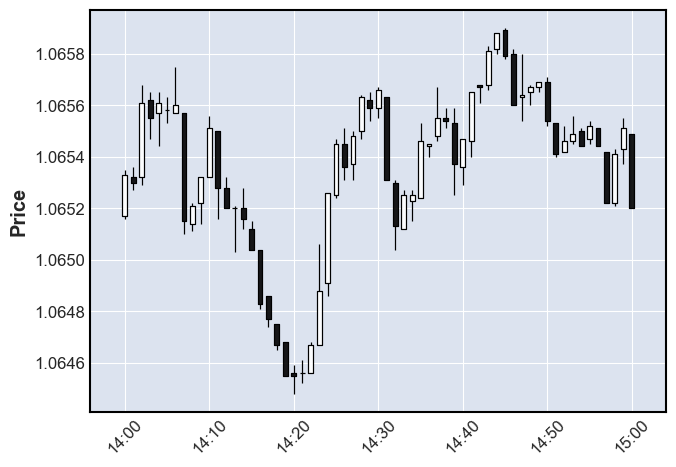

In [12]:
# Gerando o gráfico de candlestick
dias = df3.loc['2022-06-01 14:00':'2022-06-01 15:00', :]
mpf.plot(dias, type='candle')

### Preparação dos dados para os modelos de aprendizado de máquina

In [13]:
colunas = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']
df = pd.read_csv('../dataset/dataset-exemplo-202206.csv')
df.columns = colunas

df.head()

,date,time,open,high,low,close,volume
0,2022.06.01,00:01,1.07181,1.07183,1.07177,1.07181,0
1,2022.06.01,00:02,1.07182,1.07183,1.07172,1.07172,0
2,2022.06.01,00:03,1.07172,1.07172,1.07157,1.07158,0
3,2022.06.01,00:04,1.07157,1.07160,1.07151,1.07160,0
4,2022.06.01,00:05,1.07162,1.07163,1.07157,1.07162,0


In [14]:
df = df.head(3000)

#### Redimensionar os dados em X e y

In [15]:
def dimensionamento_de_dados(df, JANELA=15, previsao=1):
  X = []
  Y = []
  total = 0
  for i in range(0, len(df), 1):
    try:
      open = df.open.values.tolist()[i:i+JANELA]
      high = df.high.values.tolist()[i:i+JANELA]
      low = df.low.values.tolist()[i:i+JANELA]
      close = df.close.values.tolist()[i:i+JANELA]
      adj = df.adj.values.tolist()[i:i+JANELA]
      macd = df.macd.values.tolist()[i:i+JANELA]
      x_i = df.close.values.tolist()[i:i+JANELA]
      y_i = df.close.values.tolist()[i+JANELA+previsao]

      anterior_close = x_i[-1]
      proximo_close = y_i

      if len(close) == JANELA:
        if anterior_close < proximo_close:
          y_i = [1, 0]
        else:
          y_i = [0, 1]
          total += 1
        
        # Cálculo do zscore no intervalo de janela de tempo.
        open = (np.array(open) - np.mean(open)) / np.std(open)
        high = (np.array(high) - np.mean(high)) / np.std(high)
        low = (np.array(low) - np.mean(low)) / np.std(low)
        close = (np.array(close) - np.mean(close)) / np.std(close)
        adj = (np.array(adj) - np.mean(adj)) / np.std(adj)
        macd = (np.array(macd) - np.mean(macd)) / np.std(macd)
        X.append(np.column_stack((open, high, low, adj, close, macd)))
        Y.append(y_i)
      else:
        continue
    except Exception as e:
      print(e)
      break
  return X, Y

#### Formatar dados

In [16]:
def formatar_dados(df):
  df['adj'] = df.close.pct_change(1).shift(-1)
  df = df.dropna()
  df = df.reset_index(drop=True)
  exp1 = df.close.ewm(span=12, adjust=False).mean()
  exp2 = df.close.ewm(span=26, adjust=False).mean()
  macd = exp1-exp2
  exp3 = macd.ewm(span=9, adjust=False).mean()
  df['macd'] = exp3

  return dimensionamento_de_dados(df)

#### Montar dataset tradicional

In [17]:
# Transformar a matriz em um array
def dataset_tradicional(dados, target):
  X = []
  y = []
  for valor, t in zip(dados, target):
    new_shape = (valor.shape[0] * valor.shape[1])
    X.append(valor[:].reshape(new_shape))
    y.append(t[0])

  return X, y

In [18]:
X, y = formatar_dados(df)

list index out of range


In [19]:
X[0].shape

(15, 6)

In [20]:
X_dados_tradicional, y_dados_tradicional = dataset_tradicional(X, y)

#### Divisão do dataset em base de treino e teste

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                      X_dados_tradicional,
                                      y_dados_tradicional,
                                      test_size=0.30,
                                      shuffle=True,
                                      random_state=42
                                    )

In [22]:
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

### SVC

In [23]:
from sklearn import svm
from sklearn.svm import SVC

In [24]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)

In [27]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [28]:
print(confusion_matrix(y_test, y_pred))

[[364 102]
 [145 284]]


In [29]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.78      0.75       466
           1       0.74      0.66      0.70       429

    accuracy                           0.72       895
   macro avg       0.73      0.72      0.72       895
weighted avg       0.73      0.72      0.72       895



In [30]:
print(
    f'Precisão do modelo: {round(accuracy_score(y_test, y_pred.round())*100, 2)}%'
)

Precisão do modelo: 72.4%


### Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
random_forest = RandomForestClassifier(n_estimators=20, random_state=0)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

In [33]:
print(confusion_matrix(y_test, y_pred.round()))

[[354 112]
 [143 286]]


In [34]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.71      0.76      0.74       466
           1       0.72      0.67      0.69       429

    accuracy                           0.72       895
   macro avg       0.72      0.71      0.71       895
weighted avg       0.72      0.72      0.71       895



In [35]:
print(f'Precisão do modelo: {round(accuracy_score(y_test, y_pred.round())*100, 2)}%')

Precisão do modelo: 71.51%


### Random Forest Regressor

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [37]:
random_forest_regressor = RandomForestRegressor(n_estimators=20, random_state=0)
random_forest_regressor.fit(X_train, y_train)
y_pred = random_forest_regressor.predict(X_test)

In [38]:
print(confusion_matrix(y_test, y_pred.round()))

[[360 106]
 [148 281]]


In [39]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74       466
           1       0.73      0.66      0.69       429

    accuracy                           0.72       895
   macro avg       0.72      0.71      0.71       895
weighted avg       0.72      0.72      0.72       895



In [40]:
print(f'Precisão do modelo: {round(accuracy_score(y_test, y_pred.round())*100, 2)}%')

Precisão do modelo: 71.62%


### Gradient Boosting

In [ ]:
%pip install xgboost

In [41]:
from xgboost import XGBClassifier

In [42]:
xgb = XGBClassifier(n_estimators=100,
                    max_depth=10,
                    learning_rate=0.01,
                    subsample=1,
                    random_state=0)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [43]:
print(confusion_matrix(y_test, y_pred.round()))

[[342 124]
 [138 291]]


In [44]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       466
           1       0.70      0.68      0.69       429

    accuracy                           0.71       895
   macro avg       0.71      0.71      0.71       895
weighted avg       0.71      0.71      0.71       895



In [45]:
print(f'Precisão do modelo: {round(accuracy_score(y_test, y_pred.round())*100, 2)}%')

Precisão do modelo: 70.73%
